In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import Convex as cvx 
import MeshCat as mc 
using Test
using Random
import Convex as cvx 
import ForwardDiff as FD
import ECOS      
#include(joinpath(@__DIR__,"ref_traj.jl"))
include(joinpath(@__DIR__,"planar_hexrotor_dynamics.jl"))

  Activating environment at `~/CMU/16-745 Optimal Control/HEXROTOR_MODELING/Project.toml`


animate_hexrotor (generic function with 1 method)

In [2]:
function create_ref_hover(model, N, dt, n_inputs)
    # create a hover reference (with no pitch) for whole time period
    mass = model.mass
    kf = model.kf

    # hover altitude
    desired_altitude= 1

    # hover state
    hover_position = [0.0; 0.0; desired_altitude]  # Hover at (0, 0, 5)
    hover_velocity = [0.0; 0.0; 0.0]  # no velocity
    hover_attitude = [0.0; 0.0; 0.0]  # No roll, pitch, yaw
    hover_angvelocity= [0.0; 0.0; 0.0] # no angular velocity
    
    Xref= [zeros(12) for i = 1:N]
    for i= 1:N
        Xref[i]= [hover_position; hover_velocity; hover_attitude; hover_angvelocity]
    end

    Uref = [(9.81*mass/n_inputs)*ones(n_inputs) for i = 1:(N-1)]
    return Xref, Uref
end

create_ref_hover (generic function with 1 method)

In [3]:
# Drone parameters
Ixx= 2.331e2
Iyy= 2.322e2
Izz= 4.022e2
model = (mass= 6.728,
    J= Diagonal([Ixx, Iyy, Izz]), 
    gravity= [0,0,-9.81],
    L= 0.5375, 
    kf= 0.1, # constant thrust coefficient 
    km= 0.01, # propeller drag coefficient
    dt= 1.0 #, # 100 horizon
)

# states and controls 
nx = 12 
nu = 6

# problem size 
dt = model.dt
tf = 20
t_vec = 0:dt:tf
N = length(t_vec)


# Generate hover trajectory for hexrotor

# initial condition of zeros
x0= [0.0, 0.0, 1.0, 0.0, 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
xg= [0.0, 0.0, 1.0, 0.0, 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
X_ref, U_ref = create_ref_hover(model, N, dt, nu)


# cost terms 
Q = diagm(ones(nx))
Qf = 10*Q
R = 0.05*diagm(ones(nu))

K_matrix= []
# instantiate S and K 
P = [zeros(nx,nx) for i = 1:N]
K = [zeros(nu,nx) for i = 1:N-1]
# initialize S[N] with Qf 
P[N] = deepcopy(Qf)

# linearize the discretized dynamics about hover
# linearize about hover
X_= X_ref[1]
U_= U_ref[1]
# state_dynamics(X_)= rk4(model,hexrotor_dynamics, X_, U_, dt)
# control_dynamics(U_)= rk4(model, hexrotor_dynamics, X_, U_, dt)
# A = FD.jacobian(state_dynamics, X_)
# B = FD.jacobian(control_dynamics, U_)

# calculate A and B matrices (jacobians of discrete dynamics with respect to X and U)
A= FD.jacobian(dx -> rk4(model, hexrotor_dynamics, dx, U_, dt), X_)
B= FD.jacobian(du -> rk4(model,hexrotor_dynamics, X_, du, dt), U_)


# calculate gain, k
for k = N-1: -1:1 
    K[k]= (R + B'*P[k+1]*B)\ (B'*P[k+1]*A) 
    P[k]= Q + A'*P[k+1]*(A- B*K[k]) 
end 


X = [zeros(nx) for i = 1:N]
X[1]= x0 #+ 0.001* rand(nx) # add a little bit of noise...
#simulate this controlled system with rk4(params_real, ...)
for i = 1:N-1
    # calculate control inputs
    u_lqr = -K[i] * (X[i]- X_ref[i]) + U_ref[i]
    # simulate the system
    #X[i+1]= rk4(model, hexrotor_dynamics,X[i], u_lqr, dt)
    X[i+1]= A*(X[i]-X_ref[i]) + B*(u_lqr-U_ref[i]) +X_ref[i] 
end



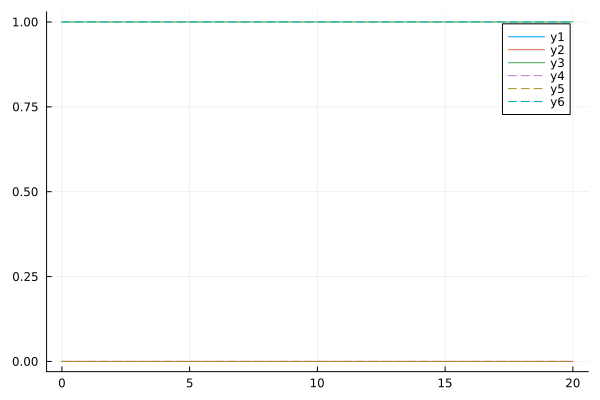

In [4]:
### plotting
Xm = hcat(X...)
plot(t_vec, Xm[1:3,:]')
Xbarm = hcat(X_ref...)
plot!(t_vec,Xbarm[1:3,:]',ls=:dash)
#display(plot!(t_vec,))


#LQR cost to go would be the cost in MPC, should exactly match LQR
#display(animate_hexrotor(Xsim, Xref, model.dt))